The MIT License (MIT)

Copyright (c) 2021 NVIDIA CORPORATION

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# GRU with MultiStage Session-based Matrix Factorization head

In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# ENSEMBLE VERSION NUMBER
VER_E = 12

# BAG MULTIPLE MLPx-RNN
VER = [31,32,33,36,40,41,44]
WEIGHT_PATH = './' #change this to list in future
RMVS = [['gap_','isweekend_', 'season_'],
       ['gap_'],
       ['isweekend_', 'season_'],
       [],
       ['isweekend_', 'season_'],
       ['isweekend_', 'season_'],
       []]

TRAIN_WITH_TEST = True
# ONLY DO THIS MANY FOLDS
DO_FOLDS = 5
# MAKE SUBMISSION OR NOT
DO_TEST = True

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import cudf
import cupy
import gc
from sklearn.model_selection import GroupKFold
pd.set_option('display.max_columns', None)

pd.__version__, cudf.__version__

('1.1.3', '0+untagged.1.ga6296e3')

In [3]:
def shift_feature(df, groupby_col, col, offset, nan=-1, colname=''):
    df[colname] = df[col].shift(offset)
    df.loc[df[groupby_col]!=df[groupby_col].shift(offset), colname] = nan

# Metric Calculation

In [4]:
# Return top4 metric
# istest: flag to select if metric should be computed in 0:train, 1:test, -1:both
# pos: select which city to calculate the metric, 0: last, 1: last-1, 2:last-2 , -1: all
# the input `val` dataframe must contains the target `city_id` and the 4 recommendations as: rec0, res1, rec2 and rec3

def top4_metric( val, istest=0, pos=0 , target='city_id'):
    
    if istest>=0:
        val = val.loc[ (val.submission==0) & (val.istest == istest) ]
    else:
        val = val.loc[ (val.submission==0) ]

    if pos >= 0:
        top1 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec0']
        top2 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec1']
        top3 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec2']
        top4 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec3']
    else:
        top1 = val[target] == val['rec0']
        top2 = val[target] == val['rec1']
        top3 = val[target] == val['rec2']
        top4 = val[target] == val['rec3']
        
    return (top1|top2|top3|top4).mean()    

# Label Encode Data

In [5]:
%%time
PATH = './'
#PATH = './cache'
raw = cudf.read_csv('../../00_Data/train_and_test_2.csv')
print(raw.shape)

(1545502, 16)
CPU times: user 939 ms, sys: 730 ms, total: 1.67 s
Wall time: 1.98 s


In [6]:
raw['reverse'] = 0
raw.head()

/opt/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/opt/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse
0,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,0,3,0
1,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,1,2,0
2,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,2,1,0
3,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal,1000027_1,0,0,0,4,0,3,0,0
4,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island,1000033_1,0,0,0,5,1,0,4,0


In [7]:
reverse = raw.copy()
reverse['reverse'] = 1
reverse['utrip_id'] = reverse['utrip_id']+'_r'

In [8]:
reverse['icount'] = reverse['dcount'].copy()

In [9]:
reverse = reverse.sort_values(['utrip_id', 'icount'], ascending=False)
raw = cudf.concat([raw, reverse], axis=0)
raw['sorting'] = cupy.asarray(range(raw.shape[0]))
del reverse
gc.collect()

10863

In [10]:
raw['utrip_id'+'_'], mp = raw['utrip_id'].factorize()

In [16]:
%%time

raw['checkin'] = cudf.to_datetime(raw.checkin, format="%Y-%m-%d")
raw['checkout'] = cudf.to_datetime(raw.checkout, format="%Y-%m-%d")

CPU times: user 8.39 ms, sys: 8.32 ms, total: 16.7 ms
Wall time: 24.3 ms


In [17]:
%%time

# ENGINEER MONTH, WEEKDAY, and LENGTH OF STAY FEATURES
raw['mn'] = raw.checkin.dt.month
raw['dy1'] = raw.checkin.dt.weekday
raw['dy2'] = raw.checkout.dt.weekday
raw['length'] = (raw.checkout - raw.checkin).dt.days

# ENGINEER WEEKEND AND SEASON
raw['day_name']= raw.checkin.dt.weekday
raw['isweekend']=raw['day_name'].isin([5,6]).astype('int8')



CPU times: user 23 ms, sys: 43.1 ms, total: 66 ms
Wall time: 93.7 ms


In [18]:
df_season = cudf.DataFrame({'mn': range(1,13), 'season': ([0]*3)+([1]*3)+([2]*3)+([3]*3)})

In [19]:
raw=raw.merge(df_season, how='left', on='mn')
raw = raw.sort_values(['sorting'], ascending=True)

In [20]:
raw.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,length,day_name,isweekend,season
1984,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,0,3,0,0,8,5,6,1,5,1,2
1985,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,1,2,0,1,8,6,1,2,6,1,2
1986,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,2,1,0,2,8,1,3,2,1,0,2
1987,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal,1000027_1,0,0,0,4,0,3,0,0,3,8,3,6,3,3,0,2
1988,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island,1000033_1,0,0,0,5,2,0,4,0,4,4,5,0,2,5,1,1


In [21]:
# WEIRD FEATURE IS DIFFERENT FOR REVERSE AND NORMAL
shift_feature(raw, 'utrip_id_', 'checkout', 1, None, 'checkout_lag1')
raw['gap'] = (raw.checkin - raw.checkout_lag1).dt.days.fillna(-1) 

In [22]:
%%time

# REVERSE ICOUNT
raw['dcount'] = raw['N']-raw['icount']-1

CPU times: user 0 ns, sys: 5.21 ms, total: 5.21 ms
Wall time: 6.15 ms


In [23]:
# LABEL ENCODE CATEGORICAL
CATS = ['city_id','mn','dy1','dy2','length','device_class','affiliate_id','booker_country',
        'hotel_country','icount','dcount','gap','isweekend', 'season']
MAPS = []
for c in CATS:
    raw[c+'_'], mp = raw[c].factorize()
    MAPS.append(mp)
    print('created',c+'_')

created city_id_
created mn_
created dy1_
created dy2_
created length_
created device_class_
created affiliate_id_
created booker_country_
created hotel_country_
created icount_
created dcount_
created gap_
created isweekend_
created season_


In [25]:
LAGS = 5
EC = 400

# ENGINEER LAG FEATURES
for i in range(1,LAGS+1):
    shift_feature(raw, 'utrip_id_', 'city_id_', i, -1, f'city_id_lag{i}')

In [26]:
shift_feature(raw, 'utrip_id_', 'hotel_country_', i, -1, 'hotel_lag1')

In [27]:
# TOTAL DURATION AND FIRST CITY
tmpA = raw[raw['icount']==0][['utrip_id', 'checkout']]
tmpB = raw[raw['dcount']==0][['utrip_id', 'checkin']]
tmpC = tmpA.merge(tmpB, how='left', on='utrip_id')
tmpC['length_total'] = (tmpC['checkout'] - tmpC['checkin']).dt.days
raw = raw.merge(tmpC[['utrip_id', 'length_total']],on='utrip_id',how='left')

In [28]:
tmpD = raw[raw['dcount']==0][['utrip_id', 'city_id_']]
tmpD.columns = ['utrip_id', 'city_first']
raw = raw.merge(tmpD,on='utrip_id',how='left')

In [29]:
tmpA = raw[raw['dcount']==0][['utrip_id', 'checkout']]
tmpB = raw[raw['icount']==0][['utrip_id', 'checkin']]
tmpC = tmpA.merge(tmpB, how='left', on='utrip_id')
tmpC['length_total_r'] = (tmpC['checkout'] - tmpC['checkin']).dt.days
raw = raw.merge(tmpC[['utrip_id', 'length_total_r']],on='utrip_id',how='left')
raw.loc[raw['length_total']<0,'length_total'] = raw.loc[raw['length_total']<0,'length_total_r']

In [30]:
raw[raw['utrip_id'].isin(['999944_1','999944_1_r'])]

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,dy2_,length_,device_class_,affiliate_id_,booker_country_,hotel_country_,icount_,dcount_,gap_,isweekend_,season_,city_id_lag1,city_id_lag2,city_id_lag3,city_id_lag4,city_id_lag5,hotel_lag1,length_total,city_first,length_total_r
1482390,999944,2016-06-23,2016-06-24,17944,desktop,4541,Gondal,Glubbdubdrib,999944_1,0,1,0,4,576692,0,3,0,1545494,6,3,4,4,0,0,1557,2,59,3,0,51,0,1,-1,-1,-1,-1,-1,-1,7,10599,-5
1482391,999944,2016-06-24,2016-06-27,47075,desktop,2322,Gondal,Glubbdubdrib,999944_1,0,1,0,4,576692,1,2,0,1545495,6,4,0,0,2,0,778,2,59,2,1,52,0,1,10599,-1,-1,-1,-1,-1,7,10599,-5
1482392,999944,2016-06-27,2016-06-29,228,desktop,384,Gondal,Glubbdubdrib,999944_1,0,1,0,4,576692,2,1,0,1545496,6,0,2,2,1,0,149,2,59,1,2,52,0,1,27893,10599,-1,-1,-1,-1,7,10599,-5
1482393,999944,2016-06-29,2016-06-30,62930,desktop,4541,Gondal,Glubbdubdrib,999944_1,0,1,0,4,576692,3,0,0,1545497,6,2,3,3,0,0,1557,2,59,0,3,52,0,1,126,27893,10599,-1,-1,-1,7,10599,-5
1548706,999944,2016-06-29,2016-06-30,62930,desktop,4541,Gondal,Glubbdubdrib,999944_1_r,0,1,0,4,576693,0,3,1,1545506,6,2,3,3,0,0,1557,2,59,3,0,51,0,1,-1,-1,-1,-1,-1,-1,7,37220,7
1548707,999944,2016-06-27,2016-06-29,228,desktop,384,Gondal,Glubbdubdrib,999944_1_r,0,1,0,4,576693,1,2,1,1545507,6,0,2,2,1,0,149,2,59,2,1,49,0,1,37220,-1,-1,-1,-1,-1,7,37220,7
1548708,999944,2016-06-24,2016-06-27,47075,desktop,2322,Gondal,Glubbdubdrib,999944_1_r,0,1,0,4,576693,2,1,1,1545508,6,4,0,0,2,0,778,2,59,1,2,47,0,1,126,37220,-1,-1,-1,-1,7,37220,7
1548709,999944,2016-06-23,2016-06-24,17944,desktop,4541,Gondal,Glubbdubdrib,999944_1_r,0,1,0,4,576693,3,0,1,1545509,6,3,4,4,0,0,1557,2,59,0,3,48,0,1,27893,126,37220,-1,-1,-1,7,37220,7


In [31]:
# CONVERT -1 TO 0
cols = [f'city_id_lag{i}' for i in range(LAGS,0,-1)]
for c in cols+['city_id_','city_first']+['hotel_lag1']:
    raw[c] += 1
    print(c)

city_id_lag5
city_id_lag4
city_id_lag3
city_id_lag2
city_id_lag1
city_id_
city_first
hotel_lag1


In [32]:
# MOVE RARE CITIES INTO COMMON CLASS
RARE = 9*2 #x2 because data has doubled
tmp = raw.city_id_.value_counts()
idx = tmp.loc[tmp<=RARE].index.values
print('rare city ct under <=%i'%RARE, len(idx),'total cities =',len(tmp) )

mx = raw.city_id_.max()+1
for c in cols+['city_first']:
    raw.loc[raw[c].isin(idx),c] = mx

rare city ct under <=18 28744 total cities = 39902


In [33]:
# VERIFY LAG LOOKS RIGHT
raw[['city_id','city_id_','icount']+cols].head()

,city_id,city_id_,icount,city_id_lag5,city_id_lag4,city_id_lag3,city_id_lag2,city_id_lag1
0,54918,32501,3,0,0,0,0,0
1,34397,20343,2,0,0,0,0,32501
2,50260,29732,1,0,0,0,32501,20343
3,52188,30865,0,0,0,32501,20343,29732
4,8462,5037,5,0,0,0,0,0


In [34]:
FEATURES = ['mn_', 'dy1_','dy2_','length_','device_class_',  'affiliate_id_', 'booker_country_',
       'hotel_lag1','icount','dcount','city_first','length_total','gap_','isweekend_', 'season_'] + cols
TARGET = ['city_id_']

**Note that the order should be ['city_id_lag3', 'city_id_lag2', 'city_id_lag1'] in the order of time for the sake of RNN**

In [35]:
cols

['city_id_lag5',
 'city_id_lag4',
 'city_id_lag3',
 'city_id_lag2',
 'city_id_lag1']

# GRU-MS-SMF 5 Fold Model

In [36]:
os.environ['TF_MEMORY_ALLOCATION'] = "0.6" # fraction of free memory

In [37]:
import tensorflow as tf
tf.__version__

'2.5.0-dev20201121'

In [38]:
gpus = tf.config.list_physical_devices('GPU')

In [39]:
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*20)]
)

In [40]:
# EMBEDDING INPUT SIZES
cts = []
for c in FEATURES:
    mx = raw[c].max()
    cts.append(mx+1)
    print(c,mx+1)

mn_ 12
dy1_ 7
dy2_ 7
length_ 30
device_class_ 3
affiliate_id_ 3611
booker_country_ 5
hotel_lag1 196
icount 48
dcount 48
city_first 39904
length_total 319
gap_ 75
isweekend_ 2
season_ 4
city_id_lag5 39904
city_id_lag4 39904
city_id_lag3 39904
city_id_lag2 39904
city_id_lag1 39904


In [41]:
# EMBEDDING OUTPUT SIZES
#EC = 400
cts2 = [4,3,3,6,2,60,3,14,7,7,200,18,9,3,4]+[EC]*len(cols)

In [42]:
emb_map = {i:(j,k) for i,j,k in zip(FEATURES, cts, cts2)}
emb_map

{'mn_': (12, 4),
 'dy1_': (7, 3),
 'dy2_': (7, 3),
 'length_': (30, 6),
 'device_class_': (3, 2),
 'affiliate_id_': (3611, 60),
 'booker_country_': (5, 3),
 'hotel_lag1': (196, 14),
 'icount': (48, 7),
 'dcount': (48, 7),
 'city_first': (39904, 200),
 'length_total': (319, 18),
 'gap_': (75, 9),
 'isweekend_': (2, 3),
 'season_': (4, 4),
 'city_id_lag5': (39904, 400),
 'city_id_lag4': (39904, 400),
 'city_id_lag3': (39904, 400),
 'city_id_lag2': (39904, 400),
 'city_id_lag1': (39904, 400)}

In [43]:
# TARGET SOFTMAX OUTPUT SIZE
t_ct = raw['city_id_'].max()+1
t_ct

39903

In [44]:
N_CITY = 50

class Linear(tf.keras.layers.Layer):
    def __init__(self, H, activation='relu'):
        super(Linear, self).__init__()
        self.dense = tf.keras.layers.Dense(H)
        self.bn = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation(activation)

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.bn(x)
        x = self.activation(x)
        return x
    

class WeightedSum(tf.keras.layers.Layer):
    def __init__(self):
        super(WeightedSum, self).__init__(name='weighted_sum')

    def build(self, input_shape):
        self.w1 = self.add_weight(name='w1',shape=None,dtype=tf.float32,
                                 trainable=True)
        self.w2 = self.add_weight(name='w2',shape=None,dtype=tf.float32,
                                 trainable=True)
        
    def call(self, x1, x2, x3):
        w1 = tf.nn.sigmoid(self.w1)
        w2 = tf.nn.sigmoid(self.w2)
        x1 = tf.stop_gradient(x1)
        x2 = tf.stop_gradient(x2)
        x3 = tf.stop_gradient(x3)
        return (x1 + x2*w1 + x3*w2)/(1+w1+w2)
    
class EmbDotSoftMax(tf.keras.layers.Layer):
    def __init__(self):
        super(EmbDotSoftMax, self).__init__()
        self.d1 = tf.keras.layers.Dense(EC) 
    
    def call(self, x, top_city_emb, top_city_id, prob):
        emb_pred = self.d1(x) # B,EC
        emb_pred = tf.expand_dims(emb_pred, axis=1) #B,1,EC
        x = emb_pred*top_city_emb #B,N_CITY,EC
        x = tf.math.reduce_sum(x, axis=2) #B,N_CITY
        x = tf.nn.softmax(x) #B,N_CITY

        rowids = tf.range(0,tf.shape(x)[0]) # B
        rowids = tf.transpose(tf.tile([rowids],[N_CITY,1])) # B,N_CITY

        idx = tf.stack([rowids,top_city_id],axis=2) # B, N_CITY, 2
        idx = tf.cast(idx, tf.int32)
        prob = tf.scatter_nd(idx, x, tf.shape(prob)) + 1e-6
        return prob
    

def build_model(FEATURES):
    inp = tf.keras.layers.Input(shape=(len(FEATURES),))
    embs = []
    i,j = emb_map['city_id_lag1']
    e_city = tf.keras.layers.Embedding(i,j)
    city_embs = []
    
    for k,f in enumerate(FEATURES):
        i,j = emb_map[f]
        if f.startswith('city_id'):
            city_embs.append(e_city(inp[:,k]))
        else:
            e = tf.keras.layers.Embedding(i,j)
            embs.append(e(inp[:,k]))
    
    xc = tf.stack(city_embs, axis=1) # B, T, F
    xc = tf.keras.layers.GRU(EC, activation='tanh')(xc)
    
    x = tf.keras.layers.Concatenate()(embs)
    x = tf.keras.layers.Concatenate()([x,xc])
    
    x1 = Linear(512+256, 'relu')(x)
    x2 = Linear(512+256, 'relu')(x1)
    prob = tf.keras.layers.Dense(t_ct,activation='softmax',name='main_output')(x2)
    
    _, top_city_id = tf.math.top_k(prob, N_CITY)  # top_city_id.shape = B,N_CITY
    top_city_emb = e_city(top_city_id) # B,N_CITY,EC
    
    x1 = Linear(512+256, 'relu')(x1)
    prob_1 = EmbDotSoftMax()(x1,top_city_emb,top_city_id,prob)
    prob_2 = EmbDotSoftMax()(x2,top_city_emb,top_city_id,prob)
    
    prob_ws = WeightedSum()(prob, prob_1, prob_2)
    
    model = tf.keras.models.Model(inputs=inp,outputs=[prob,prob_1,prob_2,prob_ws])
    opt = tf.keras.optimizers.Adam(lr=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    mtr = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=4)
    model.compile(loss=loss, optimizer = opt, metrics=[mtr])
    return model

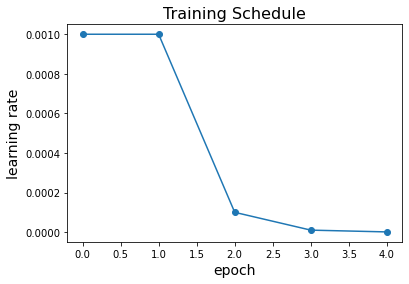

In [45]:
# CUSTOM LEARNING SCHEUDLE

def lrfn(epoch):
    rates = [1e-3,1e-3,1e-4,1e-5,1e-6]
    return rates[epoch]
    
lr = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(5)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y,'-o'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

# Predict Full OOF

In [47]:
city_mapping = MAPS[0].reset_index()

In [50]:
CHUNK = 1024*4

# LOAD SAVED MODELS
models = []
if 1:
    for k in range(DO_FOLDS):
        if k>DO_FOLDS-1: continue
            
        for i,j in enumerate(VER):
            features_ = [f for f in FEATURES if f not in RMVS[i]]
            model = build_model(features_)
            name = f'{WEIGHT_PATH}MLPx_fold{k}_v{j}.h5'
            print(name)
            model.load_weights(name)
            models.append(model)
    
valid = []
USE_K = 50

# 5 FOLD VALIDATION
for fold in range(5):
    if fold>DO_FOLDS-1: continue
    print('#'*25)
    print('### FOLD %i'%(fold+1))
    
    # ONLY VALIDATE ON LAST CITY TRAIN
    test = raw.loc[ (raw.fold==fold)&(raw.istest==0)&(raw.icount==0)&(raw.N>=4)&(raw.reverse==0) ].copy()
        
    print('### valid shape', test.shape )
    print('#'*25)

    test.reset_index(drop=True,inplace=True)
    TOP4 = np.zeros((test.shape[0],USE_K),dtype='int32')
    PROB4 = np.zeros((test.shape[0],USE_K),dtype='float32')

    print( test.shape )
    for k in range(test.shape[0]//CHUNK + 1):
        
        a = k*CHUNK
        b = (k+1)*CHUNK
        b = min(test.shape[0],b)
        
        # PREDICT MLP-RNN MODELS
        preds = np.zeros((b-a,t_ct))
        print('Fold %i Chunk %i to %i'%(fold+1,a,b))
        if 1:
            for i,j in enumerate(VER):
                print(' -model %i v%i'%(i,j))
                features_ = [f for f in FEATURES if f not in RMVS[i]]
                _,_,_,preds0 = models[fold*len(VER)+i].predict(test[features_].iloc[a:b].to_pandas(),verbose=0,batch_size=512)
                preds += preds0 / len(VER)
                                        
        for i in range(USE_K):
            x = np.argmax(preds,axis=1)
            TOP4[a:b,i] = x
            PROB4[a:b,i] = np.max(preds,axis=1)
            for j in range(preds.shape[0]):
                preds[j,x[j]] = -1
                                                                        
    for k in range(USE_K):
        test['rec%i'%k] = TOP4[:,k] - 1
        tmp = test[['rec%i'%k]].astype('int32').copy()
        tmp['sorting'] = cupy.asarray(range(tmp.shape[0]))
        tmp = tmp.merge(city_mapping, how='left', left_on='rec%i'%k, right_on='index')
        tmp = tmp.sort_values('sorting')
        test['rec%i'%k] = tmp['city_id'].values.copy()
        test['prob%i'%k] = PROB4[:,k]
        
    valid.append(test)

./MLPx_fold0_v44.h5
#########################
### FOLD 1
### valid shape (43376, 50)
#########################
(43376, 50)
Fold 1 Chunk 0 to 4096
 -model 0 v44
Fold 1 Chunk 4096 to 8192
 -model 0 v44
Fold 1 Chunk 8192 to 12288
 -model 0 v44
Fold 1 Chunk 12288 to 16384
 -model 0 v44
Fold 1 Chunk 16384 to 20480
 -model 0 v44
Fold 1 Chunk 20480 to 24576
 -model 0 v44
Fold 1 Chunk 24576 to 28672
 -model 0 v44
Fold 1 Chunk 28672 to 32768
 -model 0 v44
Fold 1 Chunk 32768 to 36864
 -model 0 v44
Fold 1 Chunk 36864 to 40960
 -model 0 v44
Fold 1 Chunk 40960 to 43376
 -model 0 v44


In [51]:
if DO_FOLDS==1:
    valid = valid[0]
else:
    valid = cudf.concat(valid,axis=0,ignore_index=True)

In [52]:
# VALIDATION LAST CITY - FULL OOF
top4_metric( valid, 0, 0, target='city_id' )

0.5452554407967539

In [53]:
CC = ['utrip_id']+['rec%i'%k for k in range(USE_K)]+['prob%i'%k for k in range(USE_K)]

In [54]:
valid[['rec%i'%k for k in range(USE_K)]] = valid[['rec%i'%k for k in range(USE_K)]].astype('int32')

In [55]:
valid[CC].head()

,utrip_id,rec0,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12,rec13,rec14,rec15,rec16,rec17,rec18,rec19,prob30,prob31,prob32,prob33,prob34,prob35,prob36,prob37,prob38,prob39,prob40,prob41,prob42,prob43,prob44,prob45,prob46,prob47,prob48,prob49
0,1237888_2,37689,15626,23940,20318,60002,8468,58178,37175,47635,43306,11481,1034,44316,17127,5085,30768,41150,15583,18771,56450,0.004407,0.004406,0.004391,0.004271,0.004119,0.004113,0.004109,0.004044,0.004008,0.003805,0.003791,0.003764,0.003751,0.003696,0.003628,0.003620,0.003316,0.003313,0.002789,0.002649
1,1265690_3,48483,25997,42682,22175,13931,63466,61942,8359,23921,7796,5325,46943,47541,9394,37496,17429,64664,60520,29990,29319,0.005954,0.005827,0.005496,0.005044,0.004951,0.004611,0.004357,0.004224,0.004213,0.004121,0.004037,0.004031,0.004015,0.003956,0.003949,0.003912,0.003747,0.003572,0.003312,0.002994
2,1174499_1,51999,8766,735,25115,16362,56872,35575,40325,41068,6005,1910,9278,60143,59887,60238,50421,1041,39133,1328,9810,0.001586,0.001478,0.001364,0.001205,0.001073,0.001050,0.001038,0.000893,0.000861,0.000843,0.000757,0.000727,0.000602,0.000572,0.000483,0.000440,0.000439,0.000413,0.000381,0.000299
3,1453716_1,23714,66648,47389,45574,19254,30520,26904,11869,61133,18417,35380,19836,37407,22689,36446,67068,14947,13942,9679,52301,0.002118,0.002055,0.002042,0.001916,0.001897,0.001863,0.001815,0.001782,0.001728,0.001679,0.001647,0.001612,0.001552,0.001422,0.001401,0.001386,0.001366,0.001366,0.001303,0.001214
4,1037361_1,5085,1034,60002,58178,37689,10992,65365,15626,36651,56450,20318,54465,44316,27115,58518,47635,47470,42370,28186,3084,0.005645,0.005625,0.005596,0.005254,0.005146,0.005145,0.005086,0.004995,0.004944,0.004864,0.004758,0.004677,0.004577,0.004396,0.004360,0.004286,0.004220,0.004178,0.004043,0.003976


In [56]:
CC2 = ['utrip_id']+['city_id_%i'%k for k in range(1,USE_K+1)]+['city_score_%i'%k for k in range(1,USE_K+1)]
for (c1,c2) in zip(CC,CC2):
    valid.rename({c1:c2},axis=1,inplace=True)
    print('renaming',c1,'to',c2)

renaming utrip_id to utrip_id
renaming rec0 to city_id_1
renaming rec1 to city_id_2
renaming rec2 to city_id_3
renaming rec3 to city_id_4
renaming rec4 to city_id_5
renaming rec5 to city_id_6
renaming rec6 to city_id_7
renaming rec7 to city_id_8
renaming rec8 to city_id_9
renaming rec9 to city_id_10
renaming rec10 to city_id_11
renaming rec11 to city_id_12
renaming rec12 to city_id_13
renaming rec13 to city_id_14
renaming rec14 to city_id_15
renaming rec15 to city_id_16
renaming rec16 to city_id_17
renaming rec17 to city_id_18
renaming rec18 to city_id_19
renaming rec19 to city_id_20
renaming rec20 to city_id_21
renaming rec21 to city_id_22
renaming rec22 to city_id_23
renaming rec23 to city_id_24
renaming rec24 to city_id_25
renaming rec25 to city_id_26
renaming rec26 to city_id_27
renaming rec27 to city_id_28
renaming rec28 to city_id_29
renaming rec29 to city_id_30
renaming rec30 to city_id_31
renaming rec31 to city_id_32
renaming rec32 to city_id_33
renaming rec33 to city_id_34
ren

In [57]:
ttrain = valid[CC2].copy()
ttrain.head()

,utrip_id,city_id_1,city_id_2,city_id_3,city_id_4,city_id_5,city_id_6,city_id_7,city_id_8,city_id_9,city_id_10,city_id_11,city_id_12,city_id_13,city_id_14,city_id_15,city_id_16,city_id_17,city_id_18,city_id_19,city_id_20,city_score_31,city_score_32,city_score_33,city_score_34,city_score_35,city_score_36,city_score_37,city_score_38,city_score_39,city_score_40,city_score_41,city_score_42,city_score_43,city_score_44,city_score_45,city_score_46,city_score_47,city_score_48,city_score_49,city_score_50
0,1237888_2,37689,15626,23940,20318,60002,8468,58178,37175,47635,43306,11481,1034,44316,17127,5085,30768,41150,15583,18771,56450,0.004407,0.004406,0.004391,0.004271,0.004119,0.004113,0.004109,0.004044,0.004008,0.003805,0.003791,0.003764,0.003751,0.003696,0.003628,0.003620,0.003316,0.003313,0.002789,0.002649
1,1265690_3,48483,25997,42682,22175,13931,63466,61942,8359,23921,7796,5325,46943,47541,9394,37496,17429,64664,60520,29990,29319,0.005954,0.005827,0.005496,0.005044,0.004951,0.004611,0.004357,0.004224,0.004213,0.004121,0.004037,0.004031,0.004015,0.003956,0.003949,0.003912,0.003747,0.003572,0.003312,0.002994
2,1174499_1,51999,8766,735,25115,16362,56872,35575,40325,41068,6005,1910,9278,60143,59887,60238,50421,1041,39133,1328,9810,0.001586,0.001478,0.001364,0.001205,0.001073,0.001050,0.001038,0.000893,0.000861,0.000843,0.000757,0.000727,0.000602,0.000572,0.000483,0.000440,0.000439,0.000413,0.000381,0.000299
3,1453716_1,23714,66648,47389,45574,19254,30520,26904,11869,61133,18417,35380,19836,37407,22689,36446,67068,14947,13942,9679,52301,0.002118,0.002055,0.002042,0.001916,0.001897,0.001863,0.001815,0.001782,0.001728,0.001679,0.001647,0.001612,0.001552,0.001422,0.001401,0.001386,0.001366,0.001366,0.001303,0.001214
4,1037361_1,5085,1034,60002,58178,37689,10992,65365,15626,36651,56450,20318,54465,44316,27115,58518,47635,47470,42370,28186,3084,0.005645,0.005625,0.005596,0.005254,0.005146,0.005145,0.005086,0.004995,0.004944,0.004864,0.004758,0.004677,0.004577,0.004396,0.004360,0.004286,0.004220,0.004178,0.004043,0.003976


# Predict Test Last City Data - 5 Folds - Submission.csv

In [58]:
test = raw.loc[ (raw.istest==1)&(raw.icount==0)&(raw.reverse==0) ].copy()
print( test.shape )
test.head()

(70662, 50)


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,dy2_,length_,device_class_,affiliate_id_,booker_country_,hotel_country_,icount_,dcount_,gap_,isweekend_,season_,city_id_lag1,city_id_lag2,city_id_lag3,city_id_lag4,city_id_lag5,hotel_lag1,length_total,city_first,length_total_r
14,1408128,2016-08-21,2016-08-23,0,desktop,4797,Gondal,<NA>,1408128_2,1,4,1,5,41910,4,0,0,112398,8,6,1,1,1,0,1639,2,-1,0,4,52,1,2,37930,31339,30557,9002,0,0,8,9002,-5
79,126569,2016-08-20,2016-08-23,0,desktop,9627,Gondal,<NA>,126569_1,1,4,1,4,27268,3,0,0,72943,8,5,1,1,2,0,3240,2,-1,0,3,52,1,2,16066,11965,39903,0,0,0,11,39903,-5
93,1265721,2016-07-07,2016-07-11,0,desktop,2661,The Devilfire Empire,<NA>,1265721_1,1,4,1,6,27274,5,0,0,72957,7,3,0,0,3,0,891,4,-1,0,5,52,0,2,6590,5717,28256,32621,38344,53,14,38344,-6
96,1085840,2016-03-10,2016-03-11,0,mobile,359,Elbonia,<NA>,1085840_1,1,1,1,7,8818,6,0,0,23456,3,3,4,4,0,1,139,1,-1,0,6,52,0,0,3980,10294,32712,18845,21282,140,11,27038,-8
105,1085852,2016-07-17,2016-07-18,0,tablet,3631,The Devilfire Empire,<NA>,1085852_1,1,3,1,9,8820,8,0,0,23465,7,6,0,0,0,2,1238,4,-1,0,8,52,1,2,39903,5446,3770,17266,31113,24,12,32138,-9


In [60]:
CHUNK = 1024*8
test.reset_index(drop=True,inplace=True)

TOP4 = np.zeros((test.shape[0],USE_K),dtype='int32')
PROB4 = np.zeros((test.shape[0],USE_K),dtype='float32')

print( test.shape )
for k in range(test.shape[0]//CHUNK + 1):
    if not DO_TEST: continue
    a = k*CHUNK
    b = (k+1)*CHUNK
    b = min(test.shape[0],b)
    
    preds = np.zeros((b-a,t_ct))

    for j in range(0,5):
        
        # MODEL MLP-RNN
        print('Fold %i Chunk %i to %i'%(j+1,a,b))
        if 1:
            for i in range(len(VER)):
                print(' -model %i v%i'%(i,VER[i]))
                features_ = [f for f in FEATURES if f not in RMVS[i]]
                test_ = test[features_].iloc[a:b]
                _,_,_,preds1 = models[j*len(VER)+i].predict(test_.to_pandas(),verbose=0,batch_size=512)
                preds += preds1 / len(VER)
                        
    preds /= 5.0
                
    for i in range(USE_K):
        x = np.argmax(preds,axis=1)
        TOP4[a:b,i] = x
        PROB4[a:b,i] = np.max(preds,axis=1)
        for j in range(preds.shape[0]):
            preds[j,x[j]] = -1

(70662, 50)
Fold 1 Chunk 0 to 8192
 -model 0 v44
Fold 1 Chunk 8192 to 16384
 -model 0 v44
Fold 1 Chunk 16384 to 24576
 -model 0 v44
Fold 1 Chunk 24576 to 32768
 -model 0 v44
Fold 1 Chunk 32768 to 40960
 -model 0 v44
Fold 1 Chunk 40960 to 49152
 -model 0 v44
Fold 1 Chunk 49152 to 57344
 -model 0 v44
Fold 1 Chunk 57344 to 65536
 -model 0 v44
Fold 1 Chunk 65536 to 70662
 -model 0 v44


In [61]:
for k in range(USE_K):
    test['rec%i'%k] = TOP4[:,k] - 1
    tmp = test[['rec%i'%k]].astype('int32').copy()
    tmp['sorting'] = cupy.asarray(range(tmp.shape[0]))
    tmp = tmp.merge(city_mapping, how='left', left_on='rec%i'%k, right_on='index')
    tmp = tmp.sort_values('sorting')
    test['rec%i'%k] = tmp['city_id'].values.copy()
    test['prob%i'%k] = PROB4[:,k]

In [62]:
test[['rec%i'%k for k in range(USE_K)]] = test[['rec%i'%k for k in range(USE_K)]].astype('int32')

In [63]:
test[CC].head()

,utrip_id,rec0,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12,rec13,rec14,rec15,rec16,rec17,rec18,rec19,prob30,prob31,prob32,prob33,prob34,prob35,prob36,prob37,prob38,prob39,prob40,prob41,prob42,prob43,prob44,prob45,prob46,prob47,prob48,prob49
0,1408128_2,47759,13260,8935,37436,42268,35160,56421,14021,45077,9485,25501,40710,20564,4268,4022,60319,27873,61804,9708,50457,0.000959,0.000918,0.000900,0.000843,0.000831,0.000772,0.000731,0.000703,0.000688,0.000651,0.000588,0.000542,0.000482,0.000458,0.000457,0.000448,0.000404,0.000328,0.000300,0.000258
1,126569_1,4476,27115,20392,3763,43560,8938,62870,59231,48503,23542,53020,39641,39718,53666,64782,1034,35985,60002,5097,44270,0.001004,0.000997,0.000991,0.000980,0.000970,0.000964,0.000938,0.000838,0.000785,0.000779,0.000775,0.000765,0.000745,0.000732,0.000712,0.000705,0.000704,0.000634,0.000622,0.000620
2,1265721_1,36063,17127,64876,19444,15377,36170,29770,64269,3763,5274,43306,22336,31093,58178,16521,47107,55128,39423,53879,55763,0.000376,0.000375,0.000359,0.000305,0.000290,0.000286,0.000281,0.000239,0.000233,0.000196,0.000191,0.000190,0.000186,0.000181,0.000179,0.000156,0.000150,0.000143,0.000132,0.000125
3,1085840_1,22297,65202,6659,1940,43524,8462,43935,49668,36530,21292,67176,60101,39509,17438,5311,2475,62910,33057,3376,53579,0.000217,0.000204,0.000200,0.000188,0.000178,0.000173,0.000164,0.000162,0.000158,0.000152,0.000152,0.000129,0.000123,0.000118,0.000096,0.000088,0.000088,0.000070,0.000070,0.000058
4,1085852_1,63284,55763,20967,9161,25946,9698,61320,47700,53213,66891,41674,39,59195,48222,6327,16280,39712,59382,38124,42359,0.000907,0.000888,0.000789,0.000771,0.000747,0.000719,0.000718,0.000684,0.000671,0.000649,0.000582,0.000581,0.000577,0.000555,0.000539,0.000497,0.000492,0.000461,0.000461,0.000456


In [64]:
CC2 = ['utrip_id']+['city_id_%i'%k for k in range(1,USE_K+1)]+['city_score_%i'%k for k in range(1,USE_K+1)]
for (c1,c2) in zip(CC,CC2):
    test.rename({c1:c2},axis=1,inplace=True)
    print('renaming',c1,'to',c2)

renaming utrip_id to utrip_id
renaming rec0 to city_id_1
renaming rec1 to city_id_2
renaming rec2 to city_id_3
renaming rec3 to city_id_4
renaming rec4 to city_id_5
renaming rec5 to city_id_6
renaming rec6 to city_id_7
renaming rec7 to city_id_8
renaming rec8 to city_id_9
renaming rec9 to city_id_10
renaming rec10 to city_id_11
renaming rec11 to city_id_12
renaming rec12 to city_id_13
renaming rec13 to city_id_14
renaming rec14 to city_id_15
renaming rec15 to city_id_16
renaming rec16 to city_id_17
renaming rec17 to city_id_18
renaming rec18 to city_id_19
renaming rec19 to city_id_20
renaming rec20 to city_id_21
renaming rec21 to city_id_22
renaming rec22 to city_id_23
renaming rec23 to city_id_24
renaming rec24 to city_id_25
renaming rec25 to city_id_26
renaming rec26 to city_id_27
renaming rec27 to city_id_28
renaming rec28 to city_id_29
renaming rec29 to city_id_30
renaming rec30 to city_id_31
renaming rec31 to city_id_32
renaming rec32 to city_id_33
renaming rec33 to city_id_34
ren

In [65]:
ttest = test[CC2].copy()
ttest.head()

,utrip_id,city_id_1,city_id_2,city_id_3,city_id_4,city_id_5,city_id_6,city_id_7,city_id_8,city_id_9,city_id_10,city_id_11,city_id_12,city_id_13,city_id_14,city_id_15,city_id_16,city_id_17,city_id_18,city_id_19,city_id_20,city_score_31,city_score_32,city_score_33,city_score_34,city_score_35,city_score_36,city_score_37,city_score_38,city_score_39,city_score_40,city_score_41,city_score_42,city_score_43,city_score_44,city_score_45,city_score_46,city_score_47,city_score_48,city_score_49,city_score_50
0,1408128_2,47759,13260,8935,37436,42268,35160,56421,14021,45077,9485,25501,40710,20564,4268,4022,60319,27873,61804,9708,50457,0.000959,0.000918,0.000900,0.000843,0.000831,0.000772,0.000731,0.000703,0.000688,0.000651,0.000588,0.000542,0.000482,0.000458,0.000457,0.000448,0.000404,0.000328,0.000300,0.000258
1,126569_1,4476,27115,20392,3763,43560,8938,62870,59231,48503,23542,53020,39641,39718,53666,64782,1034,35985,60002,5097,44270,0.001004,0.000997,0.000991,0.000980,0.000970,0.000964,0.000938,0.000838,0.000785,0.000779,0.000775,0.000765,0.000745,0.000732,0.000712,0.000705,0.000704,0.000634,0.000622,0.000620
2,1265721_1,36063,17127,64876,19444,15377,36170,29770,64269,3763,5274,43306,22336,31093,58178,16521,47107,55128,39423,53879,55763,0.000376,0.000375,0.000359,0.000305,0.000290,0.000286,0.000281,0.000239,0.000233,0.000196,0.000191,0.000190,0.000186,0.000181,0.000179,0.000156,0.000150,0.000143,0.000132,0.000125
3,1085840_1,22297,65202,6659,1940,43524,8462,43935,49668,36530,21292,67176,60101,39509,17438,5311,2475,62910,33057,3376,53579,0.000217,0.000204,0.000200,0.000188,0.000178,0.000173,0.000164,0.000162,0.000158,0.000152,0.000152,0.000129,0.000123,0.000118,0.000096,0.000088,0.000088,0.000070,0.000070,0.000058
4,1085852_1,63284,55763,20967,9161,25946,9698,61320,47700,53213,66891,41674,39,59195,48222,6327,16280,39712,59382,38124,42359,0.000907,0.000888,0.000789,0.000771,0.000747,0.000719,0.000718,0.000684,0.000671,0.000649,0.000582,0.000581,0.000577,0.000555,0.000539,0.000497,0.000492,0.000461,0.000461,0.000456


In [67]:
cudf.concat([ttrain,ttest],axis=0,ignore_index=True).to_csv('MLP-RNN_train_and_test_7runs.csv',index=False)